In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)

Device: cuda 11 / 24 / 2020


In [3]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

In [4]:
ecg_clean.shape

(5842, 1024, 1)

In [5]:
start_array_pos = 0
end_array_pos = 1000

# add double().to(device) to move the data to GPU
noise_set = torch.from_numpy(ecg_noisy).double().to(device)
clean_set = torch.from_numpy(ecg_clean).double().to(device)

# Combined dataset of noise + clean on a single dataset will be used with enumerate
combined_dataset = torch.utils.data.TensorDataset( noise_set, clean_set) # CPU version
trainloader = DataLoader( combined_dataset, shuffle=True)

# # --- Below is to limit the size of the array for faster experiments
# train_set = train_set[ start_array_pos:end_array_pos ]
# train_set = train_set.view(train_set.shape[0], 1024, 1)
# train_set.shape
# # Clean Set
# clean_set = clean_set[ start_array_pos:end_array_pos ]
# clean_set = clean_set.view(clean_set.shape[0], 1024, 1)
# clean_set.shape
# # Noise Set
# noise_set = noise_set[ start_array_pos:end_array_pos ]
# noise_set = noise_set.view(noise_set.shape[0], 1024, 1)
# noise_set.shape
# # Loader versions
# noiseloader = DataLoader( ecg_noisy[ start_array_pos:end_array_pos ], shuffle=True, num_workers=2 )
# cleanloader = DataLoader( ecg_clean[ start_array_pos:end_array_pos ], shuffle=False, num_workers=2 )

In [7]:
# kernel_size = 16
# padding_size= int( kernel_size/2 ) # If odd, add -1

# class ae_sampler(nn.Module):
#     def __init__(self):
#         super(ae_sampler, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
#             # nn.Conv1d(40, 20, kernel_size, stride=2, padding=padding_size)
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(40, 1024, 1, stride=2)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)

#         return x

In [8]:
# def train_model( model, train_set, lr, epochs):
#     lr = 1e-3 if None else lr
#     criterion = nn.MSELoss( size_average=False )
#     optimizer = torch.optim.Adam( model.parameters() )

#     mean_losses = []
#     # Iterate for each epoch
#     for epoch in range( epochs ):
#         model.train()
#         losses = []
#         # Iterate the entire data set
#         for i in train_set:
#             i = i.view( 1, i.shape[0], i.shape[1] )

#             optimizer.zero_grad()
#             x_prime = model(i)
#             loss = criterion(x_prime, i)
#             loss.backward()
#             optimizer.step()
#             losses.append(loss.item())

#         mean_loss = mean(losses)
#         mean_losses.append(mean_loss)
        # print(f"Epoch: {epoch}, Loss: {mean_loss}")

#     return mean_losses

In [9]:
# def train_model( model, train_set, lr, epochs):
#     lr = 1e-3 if None else lr
#     criterion = nn.MSELoss( size_average=False )
#     optimizer = torch.optim.Adam( model.parameters() )

#     mean_losses = []
#     # Iterate for each epoch
#     for epoch in range( epochs ):
#         model.train()
#         losses = []
#         # Iterate the entire data set
#         for i in range(len(train_set)):
#             # Clean signals
#             clean_samp = clean_set[i]
#             clean_samp = clean_samp.view( 1, clean_samp.shape[0], clean_samp.shape[1])
#             # Noise signals
#             noise_samp = noise_set[i]
#             noise_samp = noise_samp.view( 1, noise_samp.shape[0], noise_samp.shape[1])

#             optimizer.zero_grad()
#             x_prime = model(noise_samp)
#             loss = criterion(x_prime, clean_samp)
#             loss.backward()
#             optimizer.step()
#             losses.append(loss.item())

#         mean_loss = mean(losses)
#         mean_losses.append(mean_loss)
#         print(f"Epoch: {epoch}, Loss: {mean_loss}")

#     return mean_losses

In [6]:
kernel_size = 16
padding_size= int( kernel_size/2 ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
            nn.ELU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1024, 1, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [58]:
def train_model(model, trainloader, epochs):
    elapsed_start = time.time()
    train_loss = []
    criterion = nn.MSELoss( )
    optimizer = torch.optim.Adam( model.parameters() )
    
    for epoch in range(epochs):
        running_loss = 0.0
        # start time
        epoch_start = time.time()
        temp_start = time.time() # timer
        
        for i, (noise_sig, clean_sig) in enumerate(trainloader):
            optimizer.zero_grad()
            x_p = model( noise_sig )
            loss = criterion( x_p, clean_sig)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        temp_end = time.time() #timer 
        print( temp_end-temp_start)
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, epochs, loss))
        epoch_end = time.time()

        # ===== Total training elapsed time =====
        elapsed_end = time.time()
        elapsed_total = elapsed_end-elapsed_start
        print("Total elapsed time: %.2f, (in minutes %3d)" %(elapsed_total, (elapsed_total/60)))

    return train_loss

In [28]:
model = ae_sampler()
model.double()
losses = train_model( model, trainloader, 1)
# train_model( ae_sampler, noiseloader, 1)

52.64299654960632
Epoch 1 of 1, Train Loss: 1.463
Total elapsed time: 52.64, (in minutes   0)


In [13]:
# model = ae_sampler()
# model.double()
# losses = train_model( model, cleanloader, None, epochs=30)

In [14]:
x = model.encoder(noise_set)
x = model.decoder(x)
x = x.detach().numpy()
print( x.shape )

(5842, 1024, 1)


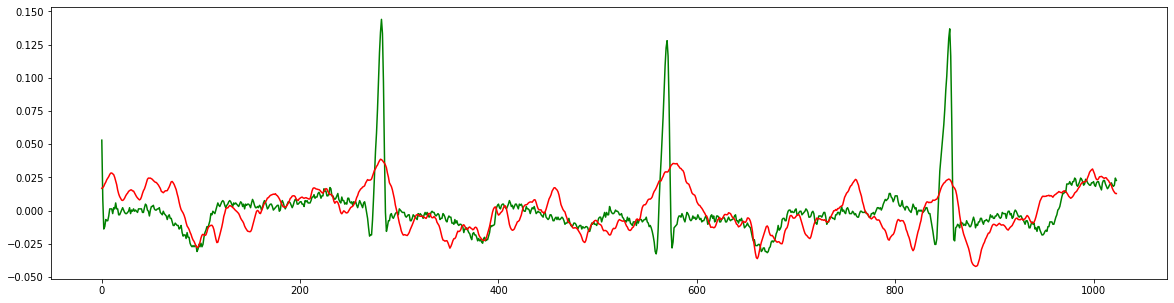

In [15]:
index_chk = 3

if x.shape[2] == 1:
    plt.figure(figsize=(20,5))
    plt.plot( clean_set[index_chk], c='green' )
    plt.plot( x[index_chk], c='red' )
else:
    print("Shape is too large")

In [16]:
from torchsummary import summary
summary( model )

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              41,984
Total params: 697,384
Trainable params: 697,384
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              41,984
Total params: 697,384
Trainable params: 697,384
Non-trainable params: 0

In [17]:
# x = torch.rand(2,3)

# x_dl = DataLoader(x, shuffle=True, num_workers=2)

# for x_i 

In [18]:
ds1 = torch.rand((4,2))
ds2 = torch.rand((4,2))

In [19]:
print( ds1 )
print( ds2 )

tensor([[0.9217, 0.0292],
        [0.9776, 0.7216],
        [0.1691, 0.9436],
        [0.7819, 0.8200]])
tensor([[0.6382, 0.1741],
        [0.9353, 0.5313],
        [0.5588, 0.3799],
        [0.5251, 0.0498]])


In [20]:
ds_combo = torch.utils.data.TensorDataset(ds1, ds2)

In [21]:
ds_dataloader = DataLoader( ds_combo, batch_size=1, shuffle=True)

In [15]:
# for m in range(2):
#     print( m )
#     for i, (ds1_x, ds2_x) in enumerate(ds_dataloader):
#         print( "ds1", ds1_x )
#         print( "ds2", ds2_x )

In [10]:
# Load CPU version of the dataset
noise_set_cpu = torch.from_numpy(ecg_clean).double()
clean_set_cpu = torch.from_numpy(ecg_clean).double()
# Combined dataset of noise + clean on a single dataset will be used with enumerate
combined_dataset_cpu = torch.utils.data.TensorDataset( noise_set_cpu, clean_set_cpu) # CPU version
trainloader_cpu = DataLoader( combined_dataset_cpu, shuffle=True)

train_loss = []
model = ae_sampler().cpu()
model.double()

criterion = nn.MSELoss( size_average=False )
optimizer = torch.optim.Adam( model.parameters() )

temp_start = time.time()


for epoch in range(2):
    
    running_loss = 0.0
    epoch_start = time.time()
    
    for i, (noise_sig, clean_sig) in enumerate(trainloader_cpu):
        optimizer.zero_grad()
        x_p = model( noise_sig )
        loss = criterion( x_p, clean_sig )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(trainloader_cpu)
    train_loss.append(loss)
    # ------------ TIMER -------------------
    epoch_end = time.time()
    time_total = epoch_end - epoch_start
    print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
    # ------------ TIMER -------------------

# end time
temp_end = time.time()

print( f'Total time: {temp_end-temp_start:.2f}' )

Epoch 1 of 2 || time: 46.34 || loss = 1.0235648610325778
Epoch 2 of 2 || time: 46.44 || loss = 0.8664501244372893
Total time: 92.78


In [11]:
model = ae_sampler().cuda()
model.double()

train_loss = []

criterion = nn.MSELoss( size_average=False )
optimizer = torch.optim.Adam( model.parameters() )


temp_start = time.time()


for epoch in range(2):
    
    running_loss = 0.0
    epoch_start = time.time()
    
    for i, (noise_sig, clean_sig) in enumerate(trainloader):
        optimizer.zero_grad()
        x_p = model( noise_sig )
        loss = criterion( x_p, clean_sig )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    # ------------ TIMER -------------------
    epoch_end = time.time()
    time_total = epoch_end - epoch_start
    print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
    # ------------ TIMER -------------------

# end time
temp_end = time.time()

print( f'Total time: {temp_end-temp_start:.2f}' )

Epoch 1 of 2 || time: 39.39 || loss = 1.5144118937430144
Epoch 2 of 2 || time: 39.61 || loss = 1.2535299171022938
Total time: 79.00
